In [32]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [45]:
subidsRest = [_id for _id in meta if 'rest' in meta[_id]]

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts_orig = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsRest]

print('Loading complete')

Loading complete


In [51]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)

print('Complete')

Complete


In [98]:
rest_ts = rest_ts_orig[877:]
print(len(rest_ts))

1


In [99]:
import torch 

rest_ts_1 = np.concatenate([ts[:,0:-1] for ts in rest_ts], axis=1).transpose([1,0])
rest_ts_2 = np.concatenate([ts[:,1:] for ts in rest_ts], axis=1).transpose([1,0])

rest_ts_t1 = torch.from_numpy(rest_ts_1).float().cuda()
rest_ts_t2 = torch.from_numpy(rest_ts_2).float().cuda()

print(rest_ts_t1.shape)
print(rest_ts_t2.shape)

torch.Size([123, 264])
torch.Size([123, 264])


In [105]:
# Simple model

nSub = len(rest_ts)
nt = rest_ts[0].shape[1]
nRoi = rest_ts[0].shape[0]
nHid = 200

import torch 
import torch.nn as nn
import torch.nn.functional as F

class DCM1(nn.Module):
    def __init__(self):
        super(DCM1, self).__init__()
        self.fc1 = nn.Linear(nRoi,nRoi).cuda()
        
    def forward(self, x):
        return self.fc1(x)
    
# Train

res = dict()
recon = dict()
nets = dict()
nIter = 5000
nPrint = 500
nSub = 20
nLoop = 3

# Train common

nEpoch = 10000
nPrint = 500
common = DCM1()
optim = torch.optim.Adam(common.parameters(), lr=1e-5)

for i in range(nEpoch):
    res = common(rest_ts_t1)
    loss = torch.sum((res-rest_ts_t2)**2)
    loss.backward()
    optim.step()
    if i%nPrint == 0 or i == nEpoch-1:
        print(f'epoch {i}, loss={loss}')

# for loop in range(0,nLoop):
#     print(f'loop {loop}')
    
#         if subj_idx not in nets:
#             net = SimpleMarkov()
#         else:
#             net = nets[subj_idx]
#         optim = torch.optim.Adam(net.parameters(), lr=1e-3)
#         running_loss = 0
#         running_window = 0
#         average_weight = torch.zeros(nRoi,nRoi).cuda()
#         average_bias = torch.zeros(nRoi).cuda()
#         if len(nets) == nSub:
#             for avgnet in nets.values():
#                 average_weight += avgnet.fc1.weight.detach()/nSub
#                 average_bias += avgnet.fc1.bias.detach()/nSub
#         for epoch in range(0,nEpoch):
#             optim.zero_grad()
#             subj_recon = net(subj_perm)
#             subj_res = subj_recon - subj_perm
#             loss_recon = torch.sum(subj_res**2)
#             loss_sparse = torch.sum(torch.abs(net.fc1.weight)) + torch.sum(torch.abs(net.fc1.bias))
#             if len(nets) == nSub:
#                 loss_diff = torch.sum((net.fc1.weight-average_weight)**2) + torch.sum((net.fc1.bias-average_bias))
#             else:
#                 loss_diff = 0
#             loss = loss_recon + 0*loss_sparse + 100*loss_diff
#             loss.backward()
#             optim.step()
#             running_loss += loss.cpu().detach()
#             running_window += 1
#             if epoch % nPrint == 0 or epoch == nEpoch - 1:
#                 print(f'\t\tepoch {epoch} loss {running_loss/running_window}')
#                 running_loss = 0
#                 running_window = 0
#         recon[subj_idx] = subj_recon.cpu().detach().numpy()
#         res[subj_idx] = subj_res.cpu().detach().numpy()
#         nets[subj_idx] = net

epoch 0, loss=43358.3125
epoch 500, loss=26833.279296875
epoch 1000, loss=19394.54296875
epoch 1500, loss=14932.9921875
epoch 2000, loss=12261.03125
epoch 2500, loss=10416.32421875
epoch 3000, loss=8922.3671875
epoch 3500, loss=7739.7119140625
epoch 4000, loss=6866.271484375
epoch 4500, loss=6205.4267578125
epoch 5000, loss=5744.4521484375
epoch 5500, loss=5448.27099609375
epoch 6000, loss=5277.31103515625
epoch 6500, loss=5211.455078125
epoch 7000, loss=5219.01220703125
epoch 7500, loss=5273.443359375
epoch 8000, loss=5341.9501953125
epoch 8500, loss=5413.544921875
epoch 9000, loss=5492.8203125
epoch 9500, loss=5589.162109375
epoch 9999, loss=5710.18359375


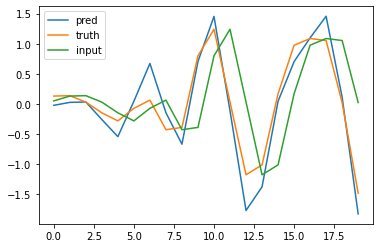

In [106]:
import matplotlib.pyplot as plt

pred = common(rest_ts_t1[0:int(nt)]).detach().cpu().numpy()
truth = rest_ts_t2[0:int(nt)].detach().cpu().numpy()
inp = rest_ts_t1[0:nt].detach().cpu().numpy()

plt.plot(pred[0:20,100], label='pred')
plt.plot(truth[0:20,100], label='truth')
plt.plot(inp[0:20,100], label='input')
plt.legend()
plt.show()

In [44]:
print(torch.max(common.fc1.weight))

tensor(0.2161, device='cuda:0', grad_fn=<MaxBackward1>)


(264,)


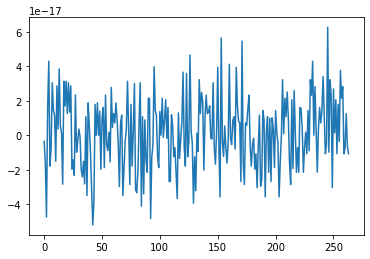

In [67]:
ms = np.mean(rest_ts[0], axis=1)
print(ms.shape)

plt.plot(ms)
plt.show()